# Entrega Nº4

Grupo formado por:
 - Javier Asensio
 - Martín de las Heras
 - Daniel Serrano
 - Elena Tornero

Para la cuarta entrega vamos a trabajar con autoencoders. 

Como sabemos, los autocodificadores son redes neuronales compuestas de dos partes:
- Una red codificadora (encoder) que comprime los datos de entrada de alta dimensión en un vector de representación de dimensión inferior.
- Una red decodificadora (decoder) que descomprime un vector de representación dado y lo devuelve al dominio original.


La red se entrena para encontrar pesos para el codificador y el decodificador que minimicen la pérdida entre la entrada original y la reconstrucción de la entrada después de que haya pasado por el codificador y el decodificador.

El vector de representación es una compresión de la señal original en un espacio latente de menor dimensión. La idea es que, eligiendo cualquier punto del espacio latente, deberíamos ser capaces de generar señales "novedosas" haciendo pasar este punto por el descodificador, ya que éste ha aprendido a convertir los puntos del espacio latente en señales viables.

Los autoencoders también pueden utilizarse para limpiar señales ruidosas, ya que el codificador aprende que no es útil capturar el ruido aleatorio dentro del espacio latente. Asimismo pueden servir para detectar posibles outliers. Para ello se evalua el error de reconstrucción y los puntos con error alto se pueden etiquetar como sospechosos. 


### Los datos
Vamos a trabajar con el dataset creditcard con el que trabajamos en el examen. Por tanto, lo primero que haremos será cargar el dataset guardar en una variable llamada X los atributos y en una variable Y las clases resultantes y lo vamos a escalar entre 0 y 1 los atributos.

In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K
import tensorflow as tf

In [3]:
file_name = 'examen-parcial-creditcard.csv'
df=pd.read_csv(file_name)
df=df.drop(columns=['Time'])
X=df.copy().drop(columns=['Class'])
Y=df['Class'].copy()
scl=MinMaxScaler()
X= pd.DataFrame(scl.fit_transform(X),columns=X.columns)

A continuación dividismos los sets  X e y cada uno de ellos en dos subsets, uno de entrenamiento y otro de validación. El de entrenamiento debería tener el 90% de los puntos y debería estar estratificado en función de los valores de Y.

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42, stratify=Y)

## Encoder

En un autoencoder, el trabajo del encoder consiste en tomar la señal de entrada y asignarla a un punto en el espacio latente.

El encoder puede ser una red con las características que se deseen. Probad con una capa oculta de 10 neuronas y un espacio latente de 5.



In [5]:
input_size = X_train.shape[1]
Hidden_size = 10
EMBEDDING_DIM = 5
encoder_input = layers.Input(shape=(input_size,), name='encoder_input')
x = layers.LeakyReLU()(encoder_input)
x = layers.Dense(Hidden_size, activation='sigmoid', name='hidden1')(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name='encoder_output')(x)
encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden1 (Dense)                 │ (None, 10)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 5)              │            55 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355 (1.39 KB)

 Trainable params: 355 (1.39 KB)

 Non-trainable params: 0 (0.00 B)

Se puede cambiar el número de capas en el codificador simplemente añadiendo elementos a las listas que definen la arquitectura del modelo. Recomiendo encarecidamente experimentar con los parámetros que definen los modelos, para entender cómo la arquitectura afecta al número de pesos en cada capa, al rendimiento del modelo y al tiempo de ejecución del modelo.

## Decoder

El decodificador es otra red cuya única caracteristica fija debe ser que su capa de salida tenga la misma dimensión que el vector de entrada. Se puede plantear como una imagen especular del codificador aunque NO necesariamente tenga que serlo.  

En resumen, puede ser lo que quieras, siempre y cuando la salida de la última capa del decodificador sea del mismo tamaño que la entrada del codificador (ya que nuestra función de pérdida comparará estos vectores).

In [6]:
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name='decoder_input')
x = layers.Dense(Hidden_size, activation='sigmoid', name='hidden_dec_1')(decoder_input)
decoder_output = layers.Dense(input_size, name='decoder_output')(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_dec_1 (Dense)            │ (None, 10)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 29)             │           319 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 379 (1.48 KB)

 Trainable params: 379 (1.48 KB)

 Non-trainable params: 0 (0.00 B)

## Estructura del autoencoder completo

Para entrenar el codificador y el decodificador simultáneamente, necesitamos definir un modelo que represente el flujo de una vector a través del codificador y de vuelta a través del decodificador. Por suerte, Keras hace que sea extremadamente fácil hacer esto.

In [7]:
autoencoder = models.Model(encoder_input, decoder(encoder_output))
autoencoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden1 (Dense)                 │ (None, 10)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_3 (Functional)       │ (None, 29)             │           379 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 734 (2.87 KB)

 Trainable params: 734 (2.87 KB)

 Non-trainable params: 0 (0.00 B)

Ahora que hemos definido nuestro modelo, sólo tenemos que compilarlo con una función de pérdida y un optimizador. La función de pérdida suele ser el error cuadrático medio (RMSE) o la entropía cruzada binaria entre los valores individuales del vector original y la reconstrucción. La entropía cruzada binaria penaliza más las predicciones en los extremos que son erróneas, por lo que tiende a empujar las predicciones de los valores hacia la mitad del rango. 

No hay una elección correcta o incorrecta: debe elegir la que mejor se adapte a su caso de uso.

In [8]:
autoencoder.compile(optimizer="adam", loss="mean_squared_error",metrics=['accuracy'])

Crea un checkpoint para salvar el modelo

In [9]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath='autoencoder.keras',
    save_best_only=True)

Ahora podemos entrenar el autoencoder pasando las valores de entrada como entrada y salida. Para ello use el set de datos de entrenamiento pasándole como entrada y salida los valores de X

In [10]:
autoencoder.fit(
    X_train,
    X_train,
    epochs=10,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test,X_test),
    callbacks=[model_checkpoint_callback]
)

Epoch 1/10
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.8820 - loss: 0.0166 - val_accuracy: 0.9915 - val_loss: 0.0012
Epoch 2/10
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9917 - loss: 0.0010 - val_accuracy: 0.9915 - val_loss: 8.0222e-04
Epoch 3/10
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9918 - loss: 7.7988e-04 - val_accuracy: 0.9915 - val_loss: 7.8435e-04
Epoch 4/10
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9921 - loss: 7.6660e-04 - val_accuracy: 0.9915 - val_loss: 7.7371e-04
Epoch 5/10
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9916 - loss: 7.6465e-04 - val_accuracy: 0.9915 - val_loss: 7.7375e-04
Epoch 6/10
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.9917 - loss: 7.6974e-04 - val_accuracy: 0.9915 - val_loss: 7.7486e-04
Epoch 7/10
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9917 - loss: 7.6094e-04 - val_accuracy: 0.9915 - val_loss: 7.7161e-04
Epoch 8/10
8011/8011 ━━━━━━━━━━━━━━━━━━

Una vez entrenado el modelo, evalue en el set de test el error de reconstrucción como la diferencia entre el vector orginal y el vector reconstruido. Guarde en un dataframe el error para cada vector de entrada y añada una columna con la verdadera clase del movimiento (si es fraudulento o no).

In [11]:
diffs = X_test - autoencoder.predict(X_test)
df = pd.DataFrame(diffs)
df.insert(0, 'Class', Y_test, True)

891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


Plotee un histograma de los errores de reconstrucción para cada tipo de movimiento (usando la densidad para que sean visibles los movimientos fraudulentos). ¿Se pueden extraer conclusiones del mismo?

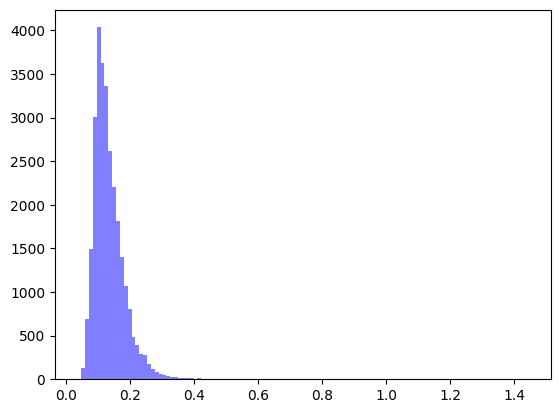

In [12]:
df['error'] = np.linalg.norm(diffs, axis=1)

plt.hist(df[df['Class'] == 0]['error'].values.flatten(), bins=100, alpha=0.5, color='blue', label='Normal')
plt.hist(df[df['Class'] == 1]['error'].values.flatten(), bins=100, alpha=0.5, color='red', label='Fraud')
plt.show()

Si se pusisese un valor de corte de 1% de los valores más altos del error de reconstrucción, ¿cuántos de los movimientos fraudulentos se detectarían?

In [13]:
threshold = np.quantile(df['error'].values.flatten(), 0.99)

df[df['error'] > threshold].groupby('Class').count()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,error
Class,,,,,,,,,,,,,,,,,,,,,
0,244,244,244,244,244,244,244,244,244,244,...,244,244,244,244,244,244,244,244,244,244
1,41,41,41,41,41,41,41,41,41,41,...,41,41,41,41,41,41,41,41,41,41


In [14]:
pd.DataFrame(Y_test).value_counts()

Class
0        28432
1           49
Name: count, dtype: int64

# Autoeconders sobrecompletos

Para la definición de un autoenconder sobrecompleto se podría hacer poniendo una capa dropout con un porcentaje dado. Defina una capa con un droput del 10% y una capa de salida del encoder mayor que la dimensión del vector de entrada y a continuación defina el decoder, entrena el modelo y vea los errores de reconstrucción. Saque las conclusiones que estime en función de los resultados que obtenga.


In [19]:
input_size = X_train.shape[1]
Hidden_size = 40
EMBEDDING_DIM_OC = input_size*2
encoder_input = layers.Input(shape=(input_size,), name='encoder_input')
x = layers.LeakyReLU()(encoder_input)
x = layers.Dropout(0.1)(x)
x = layers.Dense(Hidden_size, activation='sigmoid', name='hidden_ec_1')(x)
encoder_output = layers.Dense(EMBEDDING_DIM_OC, name='encoder_output')(x)
encoder_oc = models.Model(encoder_input, encoder_output)

decoder_input = layers.Input(shape=(EMBEDDING_DIM_OC,), name='decoder_input')
x = layers.Dense(Hidden_size, activation='sigmoid', name='hidden_dec_1')(decoder_input)
decoder_output = layers.Dense(input_size, name='decoder_output')(x)
decoder = models.Model(decoder_input, decoder_output)

autoencoder_oc = models.Model(encoder_input, decoder(encoder_output))
autoencoder_oc.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_ec_1 (Dense)             │ (None, 40)             │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 58)             │         2,378 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_11 (Functional)      │ (None, 29)             │         3,549 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,127 (27.84 KB)

 Trainable params: 7,127 (27.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9721 - loss: 0.0050 - val_accuracy: 0.9915 - val_loss: 0.0013
Epoch 2/10
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9920 - loss: 0.0013 - val_accuracy: 0.9915 - val_loss: 9.4468e-04
Epoch 3/10
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9919 - loss: 8.6070e-04 - val_accuracy: 0.9914 - val_loss: 9.3926e-04
Epoch 4/10
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.9918 - loss: 6.3542e-04 - val_accuracy: 0.9913 - val_loss: 8.2142e-04
Epoch 5/10
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.9917 - loss: 6.0494e-04 - val_accuracy: 0.9913 - val_loss: 8.3470e-04
Epoch 6/10
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9918 - loss: 5.3637e-04 - val_accuracy: 0.9912 - val_loss: 8.9463e-04
Epoch 7/10
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9917 - loss: 5.1874e-04 - val_accuracy: 0.9913 - val_loss: 9.0258e-04
Epoch 8/10
8011/8011 ━━━━━━━━━━━━━━━━━━

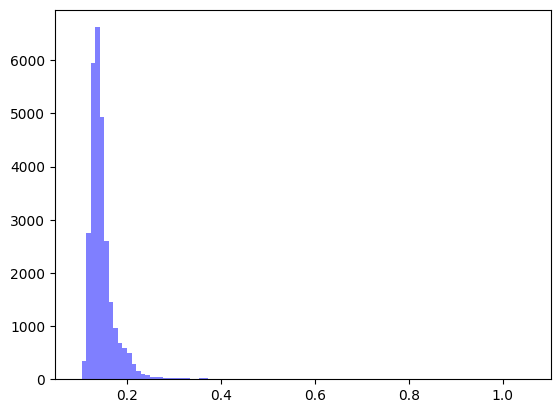

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,error
Class,,,,,,,,,,,,,,,,,,,,,
0,254,254,254,254,254,254,254,254,254,254,...,254,254,254,254,254,254,254,254,254,254
1,31,31,31,31,31,31,31,31,31,31,...,31,31,31,31,31,31,31,31,31,31


In [20]:
autoencoder_oc.compile(optimizer="adam", loss="mean_squared_error",metrics=['accuracy'])

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath='autoencoder_oc.keras',
    save_best_only=True)

autoencoder_oc.fit(
    X_train,
    X_train,
    epochs=10,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test,X_test),
    callbacks=[model_checkpoint_callback]
)

diffs_oc = X_test - autoencoder_oc.predict(X_test)
df_oc = pd.DataFrame(diffs_oc)
df_oc.insert(0, 'Class', Y_test, True)
df_oc['error'] = np.linalg.norm(diffs_oc, axis=1)

plt.hist(df_oc[df_oc['Class'] == 0]['error'].values.flatten(), bins=100, alpha=0.5, color='blue', label='Normal')
plt.hist(df_oc[df_oc['Class'] == 1]['error'].values.flatten(), bins=100, alpha=0.5, color='red', label='Fraud')
plt.show()

threshold = np.quantile(df_oc['error'].values.flatten(), 0.99)

df_oc[df_oc['error'] > threshold].groupby('Class').count()

Otra opción es incluir una regularización de la activación de la activación de la capa de salida. Testee la segunda solución sobrecompleta.

In [21]:
from tensorflow.keras import regularizers

input_size = X_train.shape[1]
EMBEDDING_DIM_OC = input_size*2
encoder_input = layers.Input(shape=(input_size,), name='encoder_input')
x = layers.LeakyReLU()(encoder_input)
x = layers.Dropout(0.1)(x)
encoder_output = layers.Dense(EMBEDDING_DIM_OC,
                              activity_regularizer=regularizers.l1(10e-5),
                              name='encoder_output')(x)
encoder_oc_v2 = models.Model(encoder_input, encoder_output)


decoder_input = layers.Input(shape=(EMBEDDING_DIM_OC,), name='decoder_input')
x = layers.Dense(Hidden_size, activation='sigmoid', name='hidden_dec_1')(decoder_input)
decoder_output = layers.Dense(input_size, name='decoder_output')(x)
decoder = models.Model(decoder_input, decoder_output)

autoencoder_oc_v2 = models.Model(encoder_input, decoder(encoder_output))
autoencoder_oc_v2.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 58)             │         1,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_17 (Functional)      │ (None, 29)             │         3,549 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,289 (20.66 KB)

 Trainable params: 5,289 (20.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.9917 - loss: 6.9546e-04 - val_accuracy: 0.9912 - val_loss: 6.9400e-04
Epoch 2/10
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9913 - loss: 6.8354e-04 - val_accuracy: 0.9911 - val_loss: 6.8390e-04
Epoch 3/10
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9917 - loss: 6.7062e-04 - val_accuracy: 0.9911 - val_loss: 6.6715e-04
Epoch 4/10
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9922 - loss: 6.5505e-04 - val_accuracy: 0.9911 - val_loss: 6.5922e-04
Epoch 5/10
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9914 - loss: 6.5469e-04 - val_accuracy: 0.9910 - val_loss: 6.5862e-04
Epoch 6/10
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - accuracy: 0.9916 - loss: 6.5201e-04 - val_accuracy: 0.9910 - val_loss: 6.5310e-04
Epoch 7/10
8011/8011 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9917 - loss: 6.4844e-04 - val_accuracy: 0.9910 - val_loss: 6.5318e-04
Epoch 8/10
8011/8011 ━━━━━━

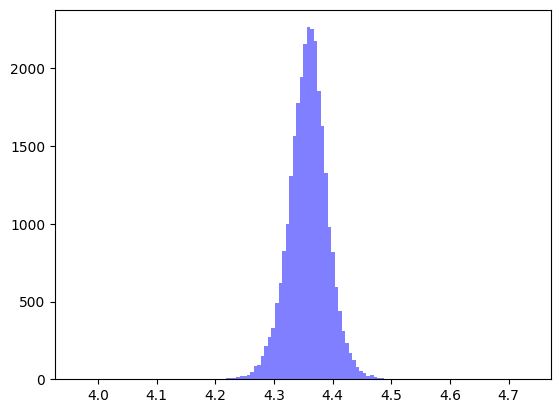

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,error
Class,,,,,,,,,,,,,,,,,,,,,
0,284,284,284,284,284,284,284,284,284,284,...,284,284,284,284,284,284,284,284,284,284
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [22]:
autoencoder_oc_v2.compile(optimizer="adam", loss="mean_squared_error",metrics=['accuracy'])

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath='autoencoder_oc_v2.keras',
    save_best_only=True)

autoencoder.fit(
    X_train,
    X_train,
    epochs=10,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test,X_test),
    callbacks=[model_checkpoint_callback]
)

diffs = X_test - autoencoder_oc_v2.predict(X_test)
df = pd.DataFrame(diffs)
df.insert(0, 'Class', Y_test, True)
df['error'] = np.linalg.norm(diffs, axis=1)

plt.hist(df[df['Class'] == 0]['error'].values.flatten(), bins=100, alpha=0.5, color='blue', label='Normal')
plt.hist(df[df['Class'] == 1]['error'].values.flatten(), bins=100, alpha=0.5, color='red', label='Fraud')
plt.show()

threshold = np.quantile(df['error'].values.flatten(), 0.99)

df[df['error'] > threshold].groupby('Class').count()

En esta práctica hemos podido aplicar los conocimientos sobre los autoencoders de cara a un caso práctico, en el cual hemos visto que con un relativamente simple autoencoder podemos discriminar la mayoría de los datos que más adelante serían considerados como fraudulentos, de la misma manera con el autoencoder sobrecompleto.